In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint
from IPython.display import clear_output
import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re

from structure_tools.Modules_tools import return_fsts

PCA_color_ref= ['darkseagreen','crimson', 'darkorange', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink']

### .vcf analysis

Jupyter notebook for the local analysis of genetic data stored in `.vcf` format.

Perform analysis of structure across data set, followed by a more detailed study of variation across local genomic windows.

### Input

In [2]:
from structure_tools.vcf_geno_tools import simple_read_vcf

vcf_file= 'data_number.vcf'

genotype, summary, info_save= simple_read_vcf(vcf_file,row_info= 5,header_info= 9,phased= False)

print('Number of markers: {}'.format(genotype.shape[1]))
print('Number of individuals: {}'.format(genotype.shape[0]))



Number of markers: 20000
Number of individuals: 200


In [3]:
summary.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT
0,1,7,1,A,T,.,PASS,.,GT:AD:DP
1,1,60,2,A,T,.,PASS,.,GT:AD:DP
2,1,78,3,A,T,.,PASS,.,GT:AD:DP
3,1,105,4,A,T,.,PASS,.,GT:AD:DP
4,1,156,5,A,T,.,PASS,.,GT:AD:DP


### Global variation

Perform PCA across data set.

Perform Mean shift clustering to attempt to extract genetically coherent groups of accessions.

These will later be used for supervised analysis.

In [4]:
n_comp= 3

In [5]:
from structure_tools.Tutorial_subplots import plot_global_pca

## Perform PCA
pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')

feats= pca.fit_transform(genotype)

In [12]:
## perform MeanShift clustering.
bandwidth = estimate_bandwidth(feats, quantile=0.3)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True, min_bin_freq=45)
ms.fit(feats)
labels1 = ms.labels_
label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1)))}


In [13]:
###
plot_global_pca(feats,label_select,PCA_color_ref,title= 'global_pca',height= 500,width= 950)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



### Local Analysis

Analyse genetic variation across genomic windows. Begin by chosing the size of each window (`window_size`) and the distance between windows (in number of markers, `Steps`).

In [14]:
summary.shape

(20000, 9)

In [15]:
from structure_tools.vcf_geno_tools import geno_window_split
##### 
window_size= 130
Steps= 25

Windows, Out= geno_window_split(genotype,
                                summary,
                                Steps= Steps,
                                window_size=window_size)

print('number of chromosomes: {}'.format(len(Windows)))
print('number of windows: {}'.format(sum([len(Windows[x].keys()) for x in Windows.keys()])))


number of chromosomes: 1
number of windows: 796


### I. Local variation sample

Visualize genetic structure at local windows using PCA. Plot colors will correspond to the Mean shift clustering above. 

Use the list `plot_who` to plot only accessions from specific groups.

Use the list `shade` to lower the opacity of samples from specific groups.

In [18]:
## a look at local windows
from structure_tools.Tutorial_subplots import window_sample_plot

windows_pick= 5
Chr= 1

ref_labels= [0,1]

plot_who= []
shade= [x for x in range(len(label_select)) if x not in ref_labels]

window_sample_plot(Windows,
                   label_select,
                   PCA_color_ref,
                   plot_who= plot_who,
                   shade= shade,
                   Chr= 1,
                   windows_pick= windows_pick,
                   height= 1500,width= 1000)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]  
[ (2,1) x3,y3 ]    [ (2,2) x4,y4 ]  
[ (3,1) x5,y5 ]    [ (3,2) x6,y6 ]  
[ (4,1) x7,y7 ]    [ (4,2) x8,y8 ]  
[ (5,1) x9,y9 ]    [ (5,2) x10,y10 ]



### II. Variation across windows.

>*i. Chose a range of windows, or a number of windows to be sampled randomly.*

>*ii. Perform PCA, AMOVA and allele frequency extraction at each window*

Analyses can be performed in either a supervised or an unsupervised manner.
For supervised analyses, use the labels from the Meanshift analysis above to chose reference labels. If the argument `include_who` is provided (list), analyses will be perform using only samples from the groups identified in that list.

>*ii. Analyse genetic distance between reference or unsupervised groups at selected windows.*

>*iii. Analyze principal component analysis projection along 1st PC across windows selected.*


- **i.** Window analysis

In [33]:
from structure_tools.Modules_tools import return_fsts2
from structure_tools.vcf_geno_tools import window_analysis, window_fst_sup

Windows_range_fst= [0,len(Windows[1])]

Fst_window= window_fst_sup(Windows,
                         ref_labels,
                         labels1,
                         Chr= 1,
                         ncomp= 4,
                        range_sample= Windows_range)

C:\Users\jgarcia\Desktop\Jupyter_stuff\Tools_and_toys\Simulate_genomes\vcf_analysis\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars



In [20]:
Windows_range_struct= [350,450]

include_who= [0,1]

Frequencies, sim_fst, Results, Construct, pc_density, pc_coords, fst_fig= window_analysis(Windows,
                                                                                 ref_labels,
                                                                                 labels1,
                                                                                 Chr= 1,
                                                                                 ncomp= 4,
                                                                                 amova= True,
                                                                                 supervised= True,
                                                                                 include_who= include_who,
                                                                                 range_sample= Windows_range_struct,
                                                                                 rand_sample= 0,
                                                                                 clsize= 15,
                                                                                 cl_freqs= 5,
                                                                                 Bandwidth_split= 20)


counting: 0.2777819164508371, Ngps: 2


In [21]:
Results['info'].head()

,chrom,window,AMOVA,Ngps
0,1.0,437689.0,0.264439,2.0
1,1.0,438998.0,0.301091,2.0
2,1.0,440041.0,0.296373,2.0
3,1.0,441489.0,0.289544,2.0
4,1.0,442572.0,0.294505,2.0


- **ii.** Fst across data sets

In [22]:
iplot(fst_fig)

In [34]:
from structure_tools.Tutorial_subplots import fst_window_plot


fst_window_plot(Fst_window,ref_labels,sort= False,window_range= Windows_range_fst)

- **iii.** PC sample distribution across data sets queried.

In [24]:
from structure_tools.Tutorial_subplots import PC_analysis_plot

labels_code= labels1
if include_who:
    labels_code= [x for x in labels_code if x in include_who]


PC_analysis_plot(pc_density,pc_coords,labels_code,PCA_color_ref,range_windows= Windows_range,plot_choice= 'coords')

### Supervised classification across windows.

Perform supervised classification of samples across local genomic windows using Kernel Density Estimation.

The function `KDE_windows` allows for an outlier threshold and a *p*-value comparison threshold for ambiguous classifications.

In [25]:
### KDE analysis across windows
from structure_tools.Sim_ideogram_tools import Merge_class, extract_profiles, KDE_windows, return_ideogram

## Use result of MS classification.
ref_labels= [0,1]
kde_class_labels= labels1

Comparison_threshold= 1
Outlier_threshold= 1e-5
n_comps= 4

color_ref= ['red','yellow','black','orange','purple','green','silver','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

ideo_kde,chromosome_list, ID, var_comp_store= KDE_windows(Windows,
                                                          kde_class_labels,
                                                          ref_labels,Out,
                                                          colors= 'alt',
                                                          n_comps=n_comps,
                                                          alt_col= color_ref,
                                                          Comparison_threshold= Comparison_threshold,
                                                          Outlier_threshold= Outlier_threshold)


adding ideograms...


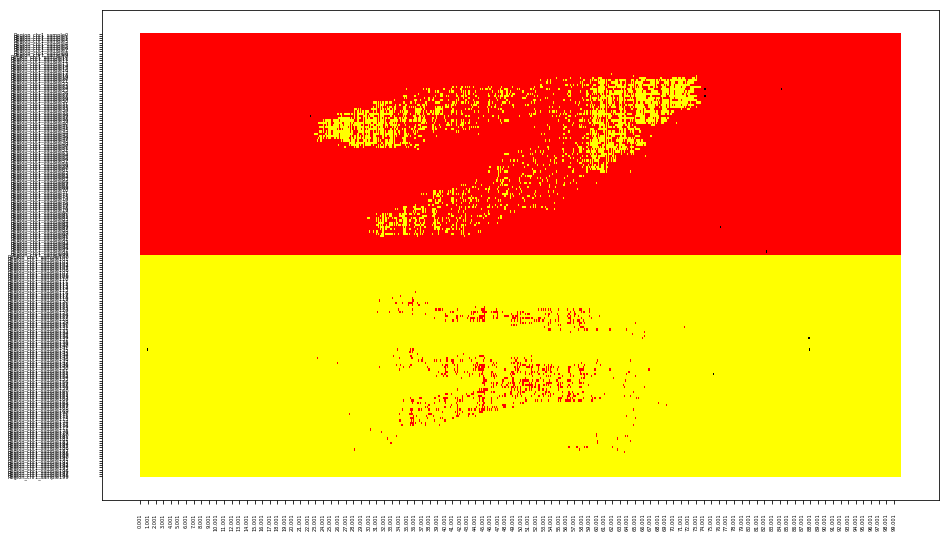

In [26]:
ID= 'custom_max_like'

Fig_ideo= return_ideogram(ideo_kde,chromosome_list,ID,height= 9,width= 15)

In [30]:
### KDE analysis across windows
from structure_tools.Sim_ideogram_tools import Merge_class, extract_profiles, KDE_windows, return_ideogram

## Use result of MS classification.
ref_labels= [0,1]
kde_class_labels= labels1

Comparison_threshold= 4
Outlier_threshold= 1e-5
n_comps= 4

color_ref= ['red','yellow','black','orange','purple','green','silver','green','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']

ideo_kde,chromosome_list, ID, var_comp_store= KDE_windows(Windows,
                                                          kde_class_labels,
                                                          ref_labels,Out,
                                                          colors= 'alt',
                                                          n_comps=n_comps,
                                                          alt_col= color_ref,
                                                          Comparison_threshold= Comparison_threshold,
                                                          Outlier_threshold= Outlier_threshold)


adding ideograms...


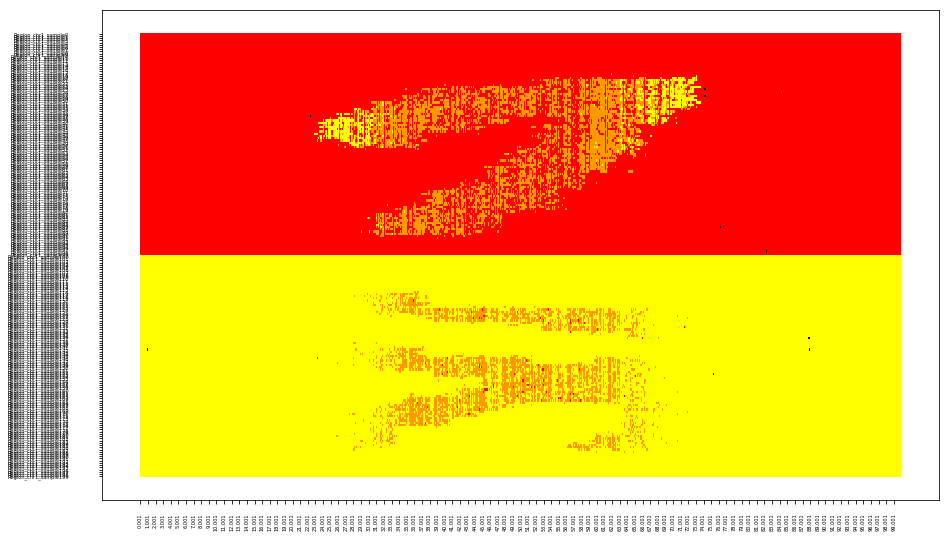

In [31]:
ID= 'custom_th' + str(Comparison_threshold)

Fig_ideo= return_ideogram(ideo_kde,chromosome_list,ID,height= 9,width= 15)